Load data
visualize regions
vertical sections
path_dat exits
path_imag exits
calc ffts and temporal averages
for satellite
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
path_dat exits
path_imag exits
calc ffts and temporal averages
for satellite
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
path_dat exits
path_imag exits
calc ffts and temporal averages
for satellite
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
path_dat exits
path_imag exits
calc ffts and temporal averages
for satellite
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
path_dat exits
path_imag exits
calc ffts and temporal averages
for satellite
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
path_dat exits
path_imag exits
calc ffts and temporal averages
for satellite
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


SystemExit: 

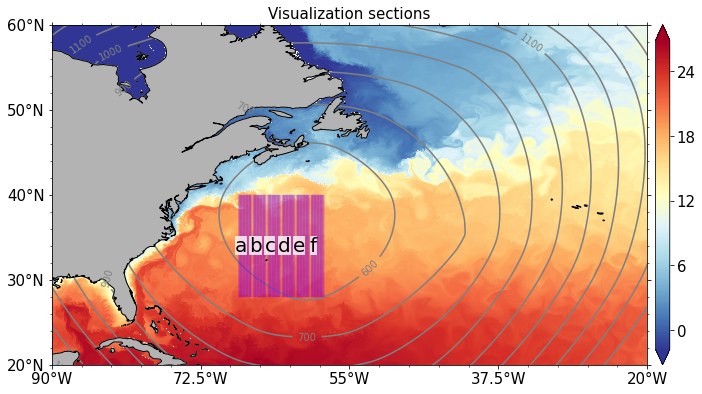

In [29]:
import warnings
warnings.filterwarnings('ignore')  #suppress some warnings about future code changes

import pandas as pd
import netCDF4 as nc
import xarray as xr    
import numpy as np
import datetime          #https://docs.python.org/3/library/datetime.html

import matplotlib.pyplot as plt
import scipy.signal as sg  #Package for signal analysis
import scipy.ndimage as si #Another package for signal analysis
from scipy.interpolate import interp1d  #for converting cell to grid-centered coordinates
from scipy import stats    #Used for 2D binned statistics
from mpl_toolkits.axes_grid1 import make_axes_locatable #For plotting interior colobars
import cartopy.crs as ccrs
ccrs_proj = ccrs.PlateCarree()
import pyicon as pyic
import glob, os     
from os import path   

import scipy
from scipy import fft as spfft
from scipy.fft import fft 
from pathlib import Path
import sys
#import importlib
from eval_funcs import *


############################################################################################################
############################################################################################################
############################################################################################################
############################################################################################################
# number of section to be smoothed in space
n = 30
#choose horizonatl or vertical
horizontal = bool(False)
calc_spectra = bool(False)

if horizontal == True: 
    parent_imag = '/work/mh0033/m300878/model_evaluation/sst/images/horizontal/'
    parent_dat  = '/work/mh0033/m300878/model_evaluation/sst/data/horizontal/'
else: 
    parent_imag = '/work/mh0033/m300878/model_evaluation/sst/images/vertical/'
    parent_dat  = '/work/mh0033/m300878/model_evaluation/sst/data/vertical/'

if calc_spectra == True:
    print('Load data')
    smt = load_smt_sst()
    ds = load_satellite_sst()



secs = 6 # number of sectionsincluded

print('visualize regions')
if horizontal == True:
    print('horizontal sections')
    regions = 'A','B','C','D','E','F'
    if calc_spectra == True: 
        plot_regions_horizontal(smt, secs, n, regions, parent_imag)
        plot_regions_horizontal_satellite(ds, secs, n, regions, parent_imag)
else:
    print('vertical sections')
    regions = 'a','b','c','d','e','f'
    if calc_spectra == True: 
        plot_regions_vertical(smt, secs, n, regions, parent_imag)
        plot_regions_vertical_satellite(ds, secs, n, regions, parent_imag)


for k in range(secs):
    if horizontal == True:
        Lat, Lon = get_lon_lat_horizontal_satellite(k, n)
    else:
        Lat, Lon = get_lon_lat_vertical_satellite(k, n)
    
    # create folder
    reg_name  = f'{regions[k]}'
    path_dat  = f'{parent_dat}{reg_name}/'
    path_imag = f'{parent_imag}{reg_name}/'

    if path.isdir(path_dat):
        print('path_dat exits')
    else:
        print('create folder path dat')
        os.mkdir(path_dat)

    if path.isdir(path_imag):
        print('path_imag exits')
    else:
        print('create folder path imag')
        os.mkdir(path_imag)

    # Do calculation? if False only plots are regenerated
    if calc_spectra == True:
        print('calc ffts and temporal averages')
        print('for satellite')

        #Satellite
        for kk in np.arange(n):
            print(kk)
            lat = Lat[kk,:]
            lon = Lon[kk,:]
            ds_section = ds.where((ds.lat > lat[0]) & (ds.lat < lat[1]) & (ds.lon > lon[0]) & (ds.lon < lon[1]), drop=True)
            ds_lat = int(ds_section.lat[0].data)
            if horizontal == True: 
                ds_section = ds_section.isel(lat=0)
                dm_sat = np.abs((ds_section.lon[1] - ds_section.lon[0])) * delta[ds_lat]
                ds_size = int(ds_section.lon.size /2) +1
            else: 
                ds_section = ds_section.isel(lon=0)
                dm_sat = np.abs((ds_section.lat[1] - ds_section.lat[0])) * delta[ds_lat]
                ds_size = int(ds_section.lat.size /2) +1
            
            dm_sat = dm_sat.data
            ###############################################################
            # satellite
            ds_size_sat = ds_size
            iii = 0
            t = 79
            A_sat = np.zeros((1,ds_size))
            for ii in np.arange(1)[::1]:
                #t_sat = ds_section.time[ii].data
                y = ds_section.isel(time=t).sst_night
                cv = y.data.compute() 
                nans, x= nan_helper(cv) 
                cv[nans]= np.interp(x(nans), x(~nans), cv[~nans])
                f, S = sg.periodogram(cv-np.nanmean(cv), fs=1/dm_sat)
                S = S.squeeze()
                A_sat[iii,:] = S
                iii += 1
            f_sat = f
            A_sat_mean = np.mean(A_sat, axis=0) # average of spectra from realisations of different timesteps
            std_sat = np.std(A_sat, axis=0)
            np.save(f'{path_dat}data_sat_{Lat[kk,0]}_{Lon[kk,0]}', [A_sat, f_sat, dm_sat, A_sat_mean, std_sat])

        # print('and for smt model')
        # # SMT Model
        # for kk in np.arange(n):
        #     print(kk)
        #     lat = Lat[kk,:]
        #     lon = Lon[kk,:]
        #     ##############################################################
        #     ######## calculate nearest neighbour of section
        #     if horizontal == True: npoints = 2300
        #     else: npoints = 1700 #2000ssh
            
        #     sname         = 'A'
        #     tgname        = 'SMT'
        #     gname         = 'OceanOnly_SubmesoNA_2500m_srtm30'
        #     path_tgrid    = f'/pool/data/ICON/oes/grids/OceanOnly/'
        #     fname_tgrid   = f'{gname}.nc'
        #     path_scratch  = f'/scratch/m/m300878/slices/'
        #     path_ckdtree  = path_scratch # where grid is stored

        #     if False: #Path(sec_path ).is_file():
        #         print ("section File exist")
        #         data = xr.open_dataset(sec_path)
        #         ickdtree = data.ickdtree_c.data
        #         lon_sec = data.lon_sec.data
        #         lat_sec = data.lat_sec.data
        #     else:
        #         print ("section file does not exist")
        #         if horizontal == True:
        #             latii = Lat[kk,:]
        #             dckdtree, ickdtree, lon_sec, lat_sec, dist_sec = pyic.ckdtree_section(p1=[lon[1],latii[0]], p2=[lon[0],latii[0]], npoints=npoints,
        #                       fname_tgrid  = fname_tgrid,
        #                       path_tgrid   = path_tgrid,
        #                       path_ckdtree = path_ckdtree,
        #                       sname = sname,
        #                       gname = gname,
        #                       tgname = tgname,
        #                       load_egrid=False,
        #                       load_vgrid=False,
        #                       )
        #         else:
        #             lonii = Lon[kk,:]
        #             dckdtree, ickdtree, lon_sec, lat_sec, dist_sec = pyic.ckdtree_section(p1=[lonii[0],lat[1]], p2=[lonii[0],lat[0]], npoints=npoints,
        #                       fname_tgrid  = fname_tgrid,
        #                       path_tgrid   = path_tgrid,
        #                       path_ckdtree = path_ckdtree,
        #                       sname = sname,
        #                       gname = gname,
        #                       tgname = tgname,
        #                       load_egrid=False,
        #                       load_vgrid=False,
        #                       )
        #         # check grid
        #         sgrid = xr.open_dataset(path_tgrid + fname_tgrid)
        #         grid  = sgrid.cell_area_p.compute()
        #         Clon  =  grid.clon * 180/np.pi
        #         grid  = grid.assign_coords(clon=Clon)
        #         Clat  =  grid.clat * 180/np.pi
        #         grid  = grid.assign_coords(clat=Clat)
        #         grid  = np.sqrt(grid.isel(cell=ickdtree))
        #         grid  = grid.assign_coords({"lon_sec": ("cell", lon_sec)})
        #         grid_smt = grid.assign_coords({"lat_sec": ("cell", lat_sec)})
        #         # section distance
        #         if horizontal == True:
        #             lat_min = int(grid_smt.lat_sec[0])
        #             d_smt_sec = (grid_smt.lon_sec[0] - grid_smt.lon_sec[1]).data *delta[lat_min]
        #         else:
        #             lat_min = int(grid_smt.lat_sec[0])
        #             d_smt_sec = (grid_smt.lat_sec[0] - grid_smt.lat_sec[1]).data *delta[lat_min]
        #         d_smt_hi_res = grid_smt.min().data
        #         print('max',grid_smt.max().data, 'min', grid_smt.min().data, 'distance section', d_smt_sec)
        #     # select data
        #     smt_sec = smt.isel(ncells=ickdtree)
        #     if horizontal == True:
        #         smt_sec = smt_sec.assign_coords({"clon": ("ncells", lon_sec)})
        #     else:
        #         smt_sec = smt_sec.assign_coords({"clat": ("ncells", lat_sec)})
            
        #     dm_smt = d_smt_sec


        #     # smt
        #     tsmt = 71*12
        #     #N = 984
        #     #l = 11
        #     #ll = int(N/l) +1
        #     ds_size = int(npoints /2) +1
        #     iii = 0   
        #     A_smt = np.zeros((1,ds_size))
        #     for ii in np.arange(1)[::1]:
        #         t_smt = smt_sec.time[tsmt].data
        #         y = smt_sec.isel(time=tsmt)
        #         cv = y.data.compute() 
        #         f, S = sg.periodogram(cv-np.mean(cv), fs=1/dm_smt)
        #         S = S.squeeze()
        #         A_smt[iii,:] = S
        #         iii += 1
        #     f_smt = f
        #     A_smt_mean = np.mean(A_smt, axis=0)
        #     std_smt = np.std(A_smt, axis=0)
        #     print(f'save averaged data in {path_dat}data_smt_{Lat[kk,0]}_{Lon[kk,0]}')
        #     np.save(f'{path_dat}data_smt_{Lat[kk,0]}_{Lon[kk,0]}', [A_smt, f_smt, dm_smt, A_smt_mean, std_smt])

    
######################################################################
# Visualization     
for K in range(secs):      
    reg_name = f'{regions[K]}'
    path_dat  = f'{parent_dat}{reg_name}/'
    path_imag = f'{parent_imag}{reg_name}/'
    
    print('plot temporal averaged')
    # plot each section
    search_str = f'data_sat*.npy' 
    flist      = np.array(glob.glob(path_dat+search_str))
    flist.sort()
    sat_sections = flist 
    search_str = f'data_smt*.npy' 
    flist      = np.array(glob.glob(path_dat+search_str))
    flist.sort()
    smt_sections = flist

    kk = 2 
    #plot time averages
    for ii in np.arange(n)[::1]:
        section = smt_sections[ii]
        [A_smt, f_smt, dm_smt, A_smt_mean, std_smt] = np.load(f'{section}',allow_pickle=True)
        section = sat_sections[ii]
        [A_sat, f_sat, dm_sat, A_sat_mean, std_sat] = np.load(f'{section}',allow_pickle=True)   
        path_save_name = f'{path_imag}sst_sec_{ii}'  
        figname = f'{reg_name}_{ii}_{section[-15:-4:]}' 
        plot_spatial_spectra_sst_horizontal(A_smt_mean, std_smt, f_smt, A_sat_mean, std_sat, f_sat, kk, figname, path_save_name, horizontal) # if activate region plot doesent work figure in figure


AAA = np.zeros((secs,A_smt_mean.size)) #A_smt_mean.size
BBB = np.zeros((secs,A_sat_mean.size)) 

fig, axs = plt.subplots(3,2, figsize=(20,25))

for K in range(secs):
    reg_name = f'{regions[K]}'
    path_dat  = f'{parent_dat}{reg_name}/'
    path_imag = f'{parent_imag}{reg_name}/'
    
    print('plot temporal & spatial averaged')
    # plot each section
    search_str = f'data_sat*.npy' 
    flist      = np.array(glob.glob(path_dat+search_str))
    flist.sort()
    sat_sections = flist 
    search_str = f'data_smt*.npy' 
    flist      = np.array(glob.glob(path_dat+search_str))
    flist.sort()
    smt_sections = flist
    # average over space n=10
    section = smt_sections[ii]
    [A_smt, f_smt, dm_smt, A_smt_mean, std_smt] = np.load(f'{section}',allow_pickle=True)
    section = sat_sections[ii]
    [A_sat, f_sat, dm_sat, A_sat_mean, std_sat] = np.load(f'{section}',allow_pickle=True)   


    AA = np.zeros((n,A_smt_mean.size))
    BB = np.zeros((n,A_sat_mean.size))

    for ii in np.arange(n):
        section = smt_sections[ii]
        [A_smt, f_smt, dm_smt, A_smt_mean, std_smt] = np.load(f'{section}',allow_pickle=True)
        AA[ii,:] = A_smt_mean
        #satelite
        section = sat_sections[ii]
        [A_sat, f_sat, dm_sat, A_sat_mean, std_sat] = np.load(f'{section}',allow_pickle=True)
        BB[ii,:] = A_sat_mean

    # C = 0
    AM = np.mean(AA, axis=0)
    BM = np.mean(BB, axis=0)
    
    AAA[K,:] = AM
    BBB[K,:] = BM
    
    AM_sem = scipy.stats.sem(AA, axis=0, ddof=1)
    AM_std = np.std(AA, axis=0, ddof=1)
    
    BM_sem = scipy.stats.sem(BB, axis=0, ddof=1)
    BM_std = np.std(BB, axis=0, ddof=1)

    #plot time and space averages
    plot_spatial_spectra6(AA, AM, AM_std, f_smt, BB, BM, BM_std, f_sat, reg_name, K, axs, horizontal, n)

path_save_name = f'{parent_imag}sst_sec_ave_reg' 
plt.savefig(f'{path_save_name}.png', bbox_inches='tight', dpi=500)

# average over all vertiacl regions
AAM = np.mean(AAA, axis=0)
BBM = np.mean(BBB, axis=0)
BBM_std = np.std(BBB, axis=0, ddof=1)
BBM_sem = scipy.stats.sem(BBB, axis=0, ddof=1)
AAM_std = np.std(AAA, axis=0, ddof=1)
AAM_sem = scipy.stats.sem(AAA, axis=0, ddof=1)

path_save_name = f'{parent_imag}sst_sec_ave_all'
reg_name='all'
plot_spatial_spectra_all_vertical(AAA, AAM, AAM_std, f_smt, BBB, BBM, BBM_std, f_sat, reg_name, path_save_name, secs, horizontal)

path_save_name = f'{parent_imag}sst_sec_ave_lat_dep'
plot_spatial_spectra_all_lat_dep(AAA, AAM, AAM_std, f_smt, BBB, BBM, BBM_std, f_sat, reg_name, path_save_name, secs, horizontal, regions)





In [30]:
A_sat

array([[1.01984376e-09, 7.80826625e+05, 1.11722875e+05, 1.24854180e+05,
        4.47202891e+04, 5.14162773e+04, 2.81468984e+04, 4.12255566e+03,
        3.04862866e+03, 2.26671704e+03, 1.17454756e+04, 2.46728301e+04,
        9.44077734e+03, 1.85124377e+03, 3.95020923e+03, 4.30789600e+03,
        4.98670703e+03, 1.46164941e+03, 4.65878662e+02, 1.30021692e+03,
        5.08754053e+03, 7.11149597e+01, 3.07678809e+03, 2.33518784e+02,
        1.68930908e+02, 1.50530615e+03, 7.09387024e+02, 1.65266187e+03,
        1.56804602e+03, 7.19435059e+02, 6.07538818e+02, 1.10301099e+03,
        2.70931592e+03, 1.25450305e+03, 1.67851318e+03, 1.94795361e+01,
        1.01732520e+03, 1.91984180e+03, 6.50327515e+02, 4.60077728e+02,
        1.96457275e+02, 1.14369373e+03, 1.54499426e+03, 7.77881409e+02,
        1.54612427e+02, 3.00794563e+01, 9.43822998e+02, 4.74576721e+02,
        1.06971191e+03, 8.69040985e+01, 5.78570618e+02, 1.01025726e+03,
        5.75353394e+02, 1.73121750e+02, 1.71443195e+01, 4.266511

plot temporal averaged
plot temporal averaged
plot temporal averaged


KeyboardInterrupt: 

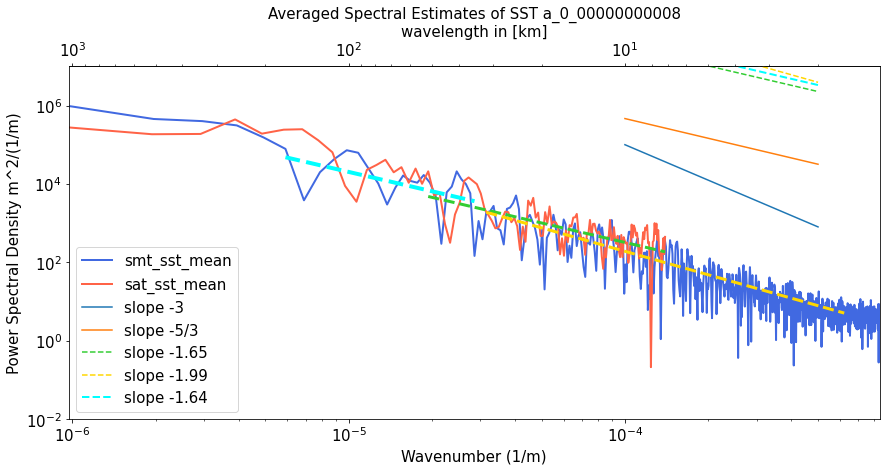

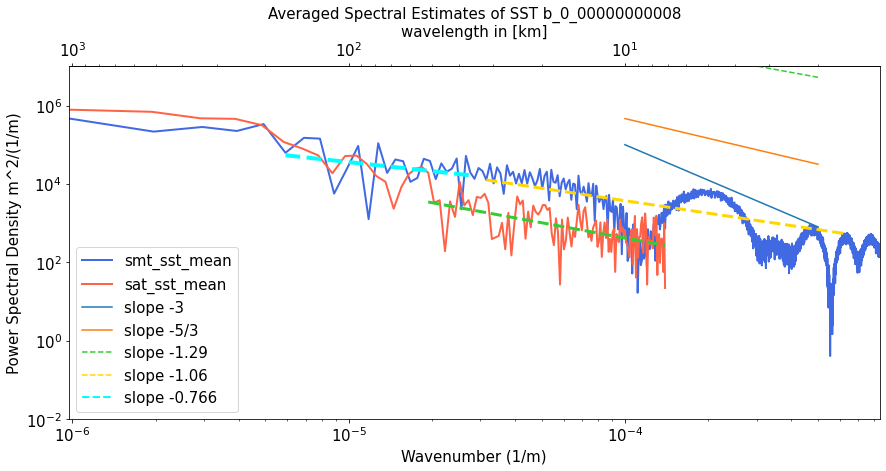

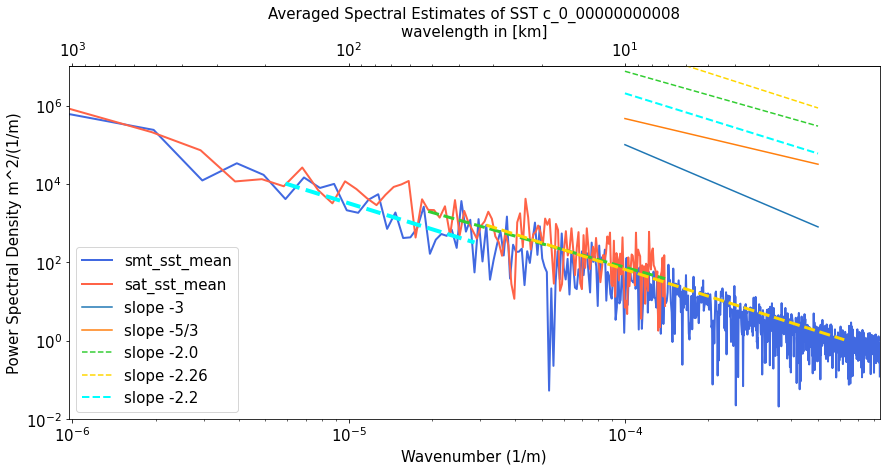

In [31]:
# Visualization     
for K in range(secs):      
    reg_name = f'{regions[K]}'
    path_dat  = f'{parent_dat}{reg_name}/'
    path_imag = f'{parent_imag}{reg_name}/'
    
    print('plot temporal averaged')
    # plot each section
    search_str = f'data_sat*.npy' 
    flist      = np.array(glob.glob(path_dat+search_str))
    flist.sort()
    sat_sections = flist 
    search_str = f'data_smt*.npy' 
    flist      = np.array(glob.glob(path_dat+search_str))
    flist.sort()
    smt_sections = flist

    kk = 2 
    #plot time averages
    for ii in np.arange(n)[::30]:
        section = smt_sections[ii]
        [A_smt, f_smt, dm_smt, A_smt_mean, std_smt] = np.load(f'{section}',allow_pickle=True)
        section = sat_sections[ii]
        [A_sat, f_sat, dm_sat, A_sat_mean, std_sat] = np.load(f'{section}',allow_pickle=True)   
        path_save_name = f'{path_imag}sst_sec_{ii}'  
        figname = f'{reg_name}_{ii}_{section[-15:-4:]}' 
        plot_spatial_spectra_sst_horizontal(A_smt_mean, std_smt, f_smt, A_sat_mean, std_sat, f_sat, kk, figname, path_save_name, horizontal) # if activate region plot doesent work figure in figure




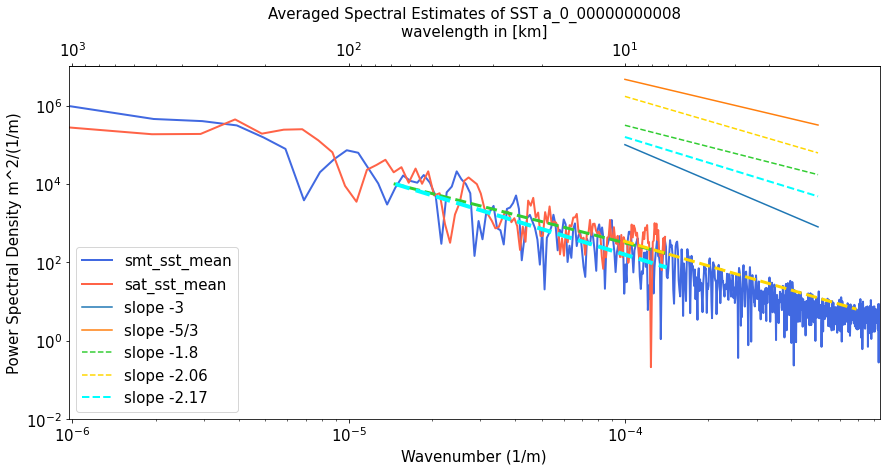

In [61]:
plot_spatial_spectra_sst_vertical(A_smt_mean, std_smt, f_smt, A_sat_mean, std_sat, f_sat, kk, figname, path_save_name, horizontal) # if activate region plot doesent work figure in figure



In [60]:
def plot_spatial_spectra_sst_vertical(A_smt_mean, std_smt, f_smt, A_sat_mean, std_sat, f_sat, k, figname, path_save_name, horizontal):
    powerlaw = lambda x, amp, index: amp * (x**index)
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))

    plt.loglog(f_smt, A_smt_mean, label='smt_sst_mean', color='royalblue', linewidth=2)
    plt.loglog(f_sat, A_sat_mean, label='sat_sst_mean', color='tomato', linewidth=2)


    add_slopes()
    x = f_smt
    def forward(x):
        return 1 / x / 1000
    def inverse(x):
        return 1 / x 
    secax = ax.secondary_xaxis('top', functions=(forward, inverse))
    secax.set_xlabel('wavelength in [km]', fontsize=15)

    ax.autoscale(enable=True, tight=True)
    ax.set_ylim(1e-2, 1e7)
    #ax.autoscale(enable=True, tight=True)
    #ax.set_xlim(1e-6, 1e10)
    fig.tight_layout()

    plt.legend(fontsize=15, loc='lower left')
    ax.tick_params(labelsize=15)
    secax.tick_params(labelsize=15)
    plt.xlabel('Wavenumber (1/m)', fontsize=15)
    plt.ylabel('Power Spectral Density m^2/(1/m)',fontsize=15)
    plt.title(f'Averaged Spectral Estimates of SST {figname}',fontsize=15)
    plt.savefig(f'{path_save_name}.png', bbox_inches='tight')


In [63]:
def add_slopes(f_sat, A_sat_mean):
#####################
    fx = np.linspace(1e-4,5e-4,100)
    pp = 1000
    y2 = pp* 3e-5*np.power(fx, (-2))
    y3 = pp* 1e-10*np.power(fx, (-3))
    y5 = pp* 1e-3*np.power(fx, (-5/3))

    plt.loglog(fx,y3, label='slope -3')
    plt.loglog(fx,y5, label='slope -5/3')

    # slope satellite
    xdata = f_sat[15:]
    ydata = A_sat_mean[15:]
    logx = np.log10(xdata)
    logy = np.log10(ydata)
    res = stats.linregress(logx, logy)
    index = res.slope
    amp = 10**res.intercept
    plt.plot(xdata, powerlaw(xdata, amp, index),linewidth=3, linestyle='dashed', color="limegreen")  
    plt.plot(fx, powerlaw(fx, pp*amp, index), linestyle='dashed', color="limegreen", label=f'slope {index:3.3}') 


    # slope smt
    if horizontal == True: 
        xdata = f_smt[300:]
        ydata = A_smt_mean[300:]
    else:
        xdata = f_smt[100::600]
        ydata = A_smt_mean[100::600]

    logx = np.log10(xdata)
    logy = np.log10(ydata)
    res = stats.linregress(logx, logy)
    index = res.slope
    amp = 10**res.intercept
    plt.plot(xdata, powerlaw(xdata, amp, index),linewidth=3, linestyle='dashed', color="gold")  
    plt.plot(fx, powerlaw(fx, 5*pp*amp, index), linestyle='dashed', color="gold", label=f'slope {index:3.3}') 

    # slope smt
    if horizontal == True:
        xdata = f_smt[20:300]
        ydata = A_smt_mean[20:300]
    else:
        xdata = f_smt[15:145]
        ydata = A_smt_mean[15:145]
    
    logx = np.log10(xdata)
    logy = np.log10(ydata)
    res = stats.linregress(logx, logy)
    index = res.slope
    amp = 10**res.intercept
    plt.plot(xdata, powerlaw(xdata, amp, index), linewidth=4, linestyle='--', color="aqua")  
    plt.plot(fx, powerlaw(fx, pp*amp, index), linewidth=2, linestyle='--', color="aqua", label=f'slope {index:3.3}') 



In [14]:
A_sat_mean

array([-8.01061173e-09, -5.47543000e+05, -1.40158906e+05, -2.22391812e+05,
       -1.45105031e+05, -1.07422430e+05, -3.43492539e+04, -3.00887891e+04,
       -9.09850391e+03, -2.97844019e+03, -2.43180586e+04, -1.72313359e+04,
       -2.17360742e+04, -2.64166016e+04, -2.85251074e+03, -1.02396356e+03,
       -6.02541553e+03, -4.44297070e+03, -7.10614551e+03, -8.30461719e+03,
       -4.95597461e+03, -3.70148291e+03, -3.02741064e+03, -1.54075513e+03,
       -1.25806934e+04, -3.82632422e+03, -3.52725220e+03, -8.00177295e+03,
       -1.01266742e+03, -9.54679321e+02, -4.55662842e+02, -9.32381653e+02,
       -3.95009888e+03, -2.86585938e+03, -2.45617090e+03, -1.71358752e+03,
       -1.45485767e+03, -2.26453644e+02, -1.23225940e+03, -3.68828247e+03,
       -1.28910693e+03, -2.80966992e+03, -2.02684363e+03, -3.05551636e+02,
       -1.20559668e+03, -4.08503357e+02, -2.74317657e+02, -1.58148340e+03,
       -2.32482788e+02, -2.79799072e+02, -1.11024158e+03, -2.52065018e+02,
       -3.40664337e+02, -

plot temporal averaged


ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 70 and the array at index 1 has size 94

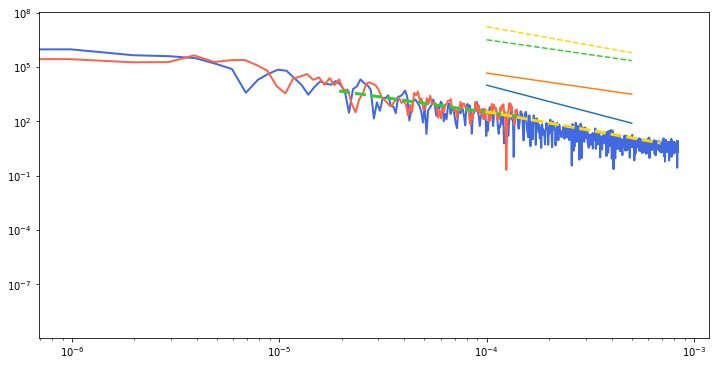

In [34]:
for K in range(1):      
    reg_name = f'{regions[K]}'
    path_dat  = f'{parent_dat}{reg_name}/'
    path_imag = f'{parent_imag}{reg_name}/'
    
    print('plot temporal averaged')
    # plot each section
    search_str = f'data_sat*.npy' 
    flist      = np.array(glob.glob(path_dat+search_str))
    flist.sort()
    sat_sections = flist 
    search_str = f'data_smt*.npy' 
    flist      = np.array(glob.glob(path_dat+search_str))
    flist.sort()
    smt_sections = flist

    kk = 2 
    #plot time averages
    for ii in np.arange(n)[::30]:
        ii = 0
        section = smt_sections[ii]
        [A_smt, f_smt, dm_smt, A_smt_mean, std_smt] = np.load(f'{section}',allow_pickle=True)
        section = sat_sections[ii]
        [A_sat, f_sat, dm_sat, A_sat_mean, std_sat] = np.load(f'{section}',allow_pickle=True)   
        path_save_name = f'{path_imag}sst_sec_{ii}'  
        figname = f'{reg_name}_{ii}_{section[-15:-4:]}' 
        plot_spatial_spectra_sst_vertical(A_smt_mean, std_smt, f_smt, A_sat_mean, std_sat, f_sat, kk, figname, path_save_name, horizontal) # if activate region plot doesent work figure in figure




In [24]:
A_sat

array([[-7.23213323e-10, -2.75638750e+05, -1.84969062e+05,
        -1.88060531e+05, -4.41334594e+05, -1.91208594e+05,
        -2.41691344e+05, -2.48019516e+05, -1.29460797e+05,
        -6.40182656e+04, -8.89087793e+03, -3.50652905e+03,
        -2.28948574e+04, -3.04373457e+04, -4.12229180e+04,
        -1.97858047e+04, -2.66842910e+04, -1.06867793e+04,
        -2.46089258e+04, -1.00657871e+04, -2.09082363e+04,
        -5.10177930e+03, -5.76699414e+03, -9.48473694e+02,
        -3.14795258e+02, -1.65831812e+03, -3.31358154e+03,
        -1.19457686e+04, -1.45983008e+04, -1.19805703e+04,
        -9.85569922e+03, -5.67802783e+03, -2.28153418e+03,
        -1.61423792e+03, -1.13818127e+03, -7.37058289e+02,
        -7.94601440e+02, -1.28174133e+03, -1.96154370e+03,
        -1.89998499e+03, -1.05394019e+03, -1.33217639e+03,
        -8.35103271e+02, -2.06374023e+02, -8.13376770e+02,
        -3.34156555e+02, -3.75178442e+03, -2.78276660e+03,
        -4.40508447e+03, -1.38173462e+03, -1.85390247e+0

In [25]:
        [A_sat, f_sat, dm_sat, A_sat_mean, std_sat] = np.load(f'{section}',allow_pickle=True)   



In [27]:
f_sat

array([-0.00000000e+00, -9.70350785e-07, -1.94070157e-06, -2.91105236e-06,
       -3.88140314e-06, -4.85175393e-06, -5.82210471e-06, -6.79245550e-06,
       -7.76280628e-06, -8.73315707e-06, -9.70350785e-06, -1.06738586e-05,
       -1.16442094e-05, -1.26145602e-05, -1.35849110e-05, -1.45552618e-05,
       -1.55256126e-05, -1.64959634e-05, -1.74663141e-05, -1.84366649e-05,
       -1.94070157e-05, -2.03773665e-05, -2.13477173e-05, -2.23180681e-05,
       -2.32884188e-05, -2.42587696e-05, -2.52291204e-05, -2.61994712e-05,
       -2.71698220e-05, -2.81401728e-05, -2.91105236e-05, -3.00808743e-05,
       -3.10512251e-05, -3.20215759e-05, -3.29919267e-05, -3.39622775e-05,
       -3.49326283e-05, -3.59029791e-05, -3.68733298e-05, -3.78436806e-05,
       -3.88140314e-05, -3.97843822e-05, -4.07547330e-05, -4.17250838e-05,
       -4.26954346e-05, -4.36657853e-05, -4.46361361e-05, -4.56064869e-05,
       -4.65768377e-05, -4.75471885e-05, -4.85175393e-05, -4.94878901e-05,
       -5.04582408e-05, -